# Grow Op Farms Lab Selection Analysis -- **NOT FINISHED**

This notebook determines the lab Grow Op Farms should use to maximize THC results on their products.

## Imports

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot



sys.path.insert(0, '..')
from scripts.helper_functions import ecdf, bootstrap_confidence_interval, bootstrap

plt.style.use('ggplot')

lic_data = pd.read_csv('../data/licensees_year_Nonemonth_None.csv/part-00000-e336c06b-db61-472c-8357-de32b6d8a4df-c000.csv')
lab_data = pd.read_csv('../data/lab_results_all')

## Data Overview

This isn't our first pass on this data. It's already been cut up by our pyspark data pipeline. Here we take a further look at the entire set of licensees and all the lab results that were created in 2020.  

In [2]:
lic_data.head()

global_id                     created_at external_id        name  \
0  WAWA1.MM1  1900-01-01T00:00:00.000-08:00           1    WA State   
1  WAWA1.MM2  1900-01-01T00:00:00.000-08:00        1111    LCB Grow   
2  WAWA1.MM3  1900-01-01T00:00:00.000-08:00        2222     LCB Mfg   
3  WAWA1.MM4  1900-01-01T00:00:00.000-08:00        3333  LCB Retail   
4  WAWA1.MM5  1900-01-01T00:00:00.000-08:00        4444     LCB Lab   

         type  
0       state  
1  cultivator  
2  production  
3  dispensary  
4         lab

In [3]:
lab_data.head()

Unnamed: 0      global_id           created_at       mme_id      user_id  \
0           0  WAL20.LR13GJS  2020-01-01 05:33:50  WAWA1.MM1VC  WAWA1.US2VM   
1           1  WAL20.LR13GJT  2020-01-01 05:33:51  WAWA1.MM1VC  WAWA1.US2VM   
2           2  WAL20.LR13GJU  2020-01-01 05:33:51  WAWA1.MM1VC  WAWA1.US2VM   
3           3   WAL3.LR13GJV  2020-01-01 22:13:10  WAWA1.MM1L2  WAWA1.US2IP   
4           4   WAL3.LR13GJW  2020-01-01 22:14:33  WAWA1.MM1L2  WAWA1.US2IP   

     external_id   inventory_id           updated_at  status testing_status  \
0  P191227-4 001  WAL20.INFMAK8  2020-01-01 05:33:51  passed      completed   
1  P191227-4 002  WAL20.INFMAK9  2020-01-01 05:33:51  passed      completed   
2  P191227-4 003  WAL20.INFMAKA  2020-01-01 05:33:51  passed      completed   
3            NaN   WAL3.INFPXAD  2020-01-03 09:28:50  failed    in_progress   
4            NaN   WAL3.INFPXAN  2020-01-05 12:20:24  failed    in_progress   

        batch_id  for_mme_id  lab_user_id                  type  \
0  WAL20.BAFRDM6  WAWA1.MMD8  WAWA1.US2VM     harvest_materials   
1  WAL20.BAFRDM7  WAWA1.MMD8  WAWA1.US2VM  intermediate_product   
2  WAL20.BAFRDM8  WAWA1.MMD8  WAWA1.US2VM           end_product   
3   WAL3.BAFUARZ  WAWA1.MMX7  WAWA1.US2IP             marijuana   
4   WAL3.BAFUASE  WAWA1.MMUT  WAWA1.US2IP             marijuana   

  cannabinoid_status  cannabinoid_editor  cannabinoid_d9_thc_percent  \
0          completed                 NaN                       0.465   
1          completed                 NaN                      18.137   
2          completed                 NaN                       0.102   
3                NaN                 NaN                         NaN   
4                NaN                 NaN                         NaN   

   cannabinoid_cbd_percent  cannabinoid_cbda_percent  
0                      0.0                       0.0  
1                      0.0                       0.0  
2                      0.0                       0.0  
3                      NaN                       NaN  
4                      NaN                       NaN

We need to merge these to dataframes together so we can get the lab and requester names for each lab test. 

In [4]:
df = lab_data.merge(lic_data, how='left', left_on='mme_id', right_on='global_id') # 1st merge gets lab name

df = df.drop(columns=['cannabinoid_cbd_percent', 'user_id', 'inventory_id', 'external_id_x', 'global_id_y'
                      , 'updated_at', 'status', 'testing_status', 'cannabinoid_status', 'external_id_y'
                      , 'cannabinoid_editor', 'lab_user_id','cannabinoid_cbda_percent'])

df = df.merge(lic_data, how='left', left_on='for_mme_id', right_on='global_id') # 2nd merge gets requester's name

df = df.drop(columns=['global_id', 'created_at', 'external_id', 'created_at_x', 'created_at_y', 'global_id'])
df = df.iloc[: , 1:] # drops extra index

Let's rename a few of these columns to be more descriptive. 

In [5]:
df = df.rename(columns={'name_x': 'lab_name'
                   , 'type_y': 'lab_business_type'
                   , 'nameglobal_id': 'requester_name'
                   , 'type': 'requester_business_type'
                   , 'name_y': 'requester_name'
                   , 'type_x': 'material_type'
                   , 'global_id_x': 'test_id'})

Next lets check for nulls. 

In [6]:
df.isnull().sum() / len(df)

test_id                       0.00000
mme_id                        0.00000
batch_id                      0.00000
for_mme_id                    0.00000
material_type                 0.00000
cannabinoid_d9_thc_percent    0.06466
lab_name                      0.00000
lab_business_type             0.00000
requester_name                0.00000
requester_business_type       0.00000
dtype: float64

6.5% if our tests did not test for THC D9. This is shouldn't be concerning because not all requesters will want this test. We will drop all of these test's since they provide no insight to the THC levels of a product.

In [7]:
df.dropna(inplace=True) # this is okay since cannabinoid_d9_thc_percent is the only column with nulls.

In [8]:
df.tail()

test_id       mme_id       batch_id  for_mme_id  \
141126  WAL22.LR16HFY  WAWA1.MM1LF  WAL22.BALUDBD  WAWA1.MME6   
141127  WAL22.LR16HFZ  WAWA1.MM1LF  WAL22.BALUFTG  WAWA1.MMV9   
141128  WAL22.LR16HG0  WAWA1.MM1LF  WAL22.BALUFTH  WAWA1.MMV9   
141129  WAL22.LR16HG1  WAWA1.MM1LF  WAL22.BALUFTF  WAWA1.MMV9   
141132  WAL22.LR16HG4  WAWA1.MM1LF  WAL22.BALUFTI  WAWA1.MMV9   

               material_type  cannabinoid_d9_thc_percent          lab_name  \
141126  intermediate_product                        2.75  CAPITOL ANALYSIS   
141127  intermediate_product                       77.92  CAPITOL ANALYSIS   
141128  intermediate_product                       11.85  CAPITOL ANALYSIS   
141129  intermediate_product                        1.86  CAPITOL ANALYSIS   
141132  intermediate_product                       74.34  CAPITOL ANALYSIS   

       lab_business_type               requester_name requester_business_type  
141126               lab                 AGRO COUTURE   cultivator_production  
141127               lab  CANNABIS NORTHWEST C-M, INC              production  
141128               lab  CANNABIS NORTHWEST C-M, INC              production  
141129               lab  CANNABIS NORTHWEST C-M, INC              production  
141132               lab  CANNABIS NORTHWEST C-M, INC              production

We will now confirm no nulls exist (all cols should have the same non-null value) and our data types are what we want them to be--the only one that really matters is cannabinoid_d9_thc_percent--and it should be a float.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132012 entries, 0 to 141132
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   test_id                     132012 non-null  object 
 1   mme_id                      132012 non-null  object 
 2   batch_id                    132012 non-null  object 
 3   for_mme_id                  132012 non-null  object 
 4   material_type               132012 non-null  object 
 5   cannabinoid_d9_thc_percent  132012 non-null  float64
 6   lab_name                    132012 non-null  object 
 7   lab_business_type           132012 non-null  object 
 8   requester_name              132012 non-null  object 
 9   requester_business_type     132012 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.1+ MB


The result is exactly what we were hoping for. Lets extract all the records for our target business--Grow Op Farms. 

In [10]:
df_by_requester = df.groupby('requester_name')
grow_op = df_by_requester.get_group('GROW OP FARMS')
grow_op = grow_op.copy() # avoid setting to a view warning
grow_op.head()

test_id       mme_id       batch_id  for_mme_id      material_type  \
243  WAL12.LR13GQJ  WAWA1.MM1L9  WAL12.BAFT7WB  WAWA1.MM7A  harvest_materials   
246  WAL12.LR13GQM  WAWA1.MM1L9  WAL12.BAFT7WC  WAWA1.MM7A  harvest_materials   
248  WAL12.LR13GQO  WAWA1.MM1L9  WAL12.BAFT7WD  WAWA1.MM7A  harvest_materials   
249  WAL12.LR13GQP  WAWA1.MM1L9  WAL12.BAFT7WE  WAWA1.MM7A  harvest_materials   
250  WAL12.LR13GQQ  WAWA1.MM1L9  WAL12.BAFT7WF  WAWA1.MM7A  harvest_materials   

     cannabinoid_d9_thc_percent           lab_name lab_business_type  \
243                        0.80  Green Grower Labs               lab   
246                        0.73  Green Grower Labs               lab   
248                        0.72  Green Grower Labs               lab   
249                        0.67  Green Grower Labs               lab   
250                        0.61  Green Grower Labs               lab   

    requester_name requester_business_type  
243  GROW OP FARMS   cultivator_production  
246  GROW OP FARMS   cultivator_production  
248  GROW OP FARMS   cultivator_production  
249  GROW OP FARMS   cultivator_production  
250  GROW OP FARMS   cultivator_production

Let's plot the KDE for cannabinoid_d9_thc_percent since it looks like our percentages may be in decimal form.

''

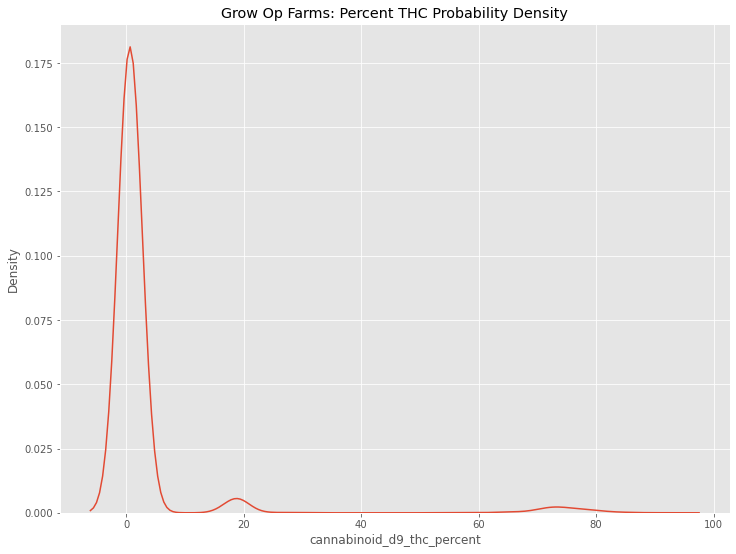

In [11]:
fig, ax = plt.subplots(figsize=(12,9))
sns.kdeplot(grow_op['cannabinoid_d9_thc_percent'], label='THC D9 %', ax=ax)
ax.set_title('Grow Op Farms: Percent THC Probability Density')
;

It is possible these tests are for goods that are bound for a state where THC is illegal and must conform to strict THC limits. However, if this is the case we should see a bimodal distribution due to the two different normal distributions with a large mean delta being combined. Therefore, it is more likely these are just decimal form percentages. To fix this we will multiply all values below 1 by 100. While we are at it we will also drop values below 0 and above 100.

In [12]:
grow_op['cannabinoid_d9_thc_percent'] = ([percent if percent > 1 else percent*100 for percent in grow_op['cannabinoid_d9_thc_percent'].values])
print('Max: ',max(grow_op['cannabinoid_d9_thc_percent'])
      ,'\nMin: ', min(grow_op['cannabinoid_d9_thc_percent']))

Max:  100.0 
Min:  0.0


''

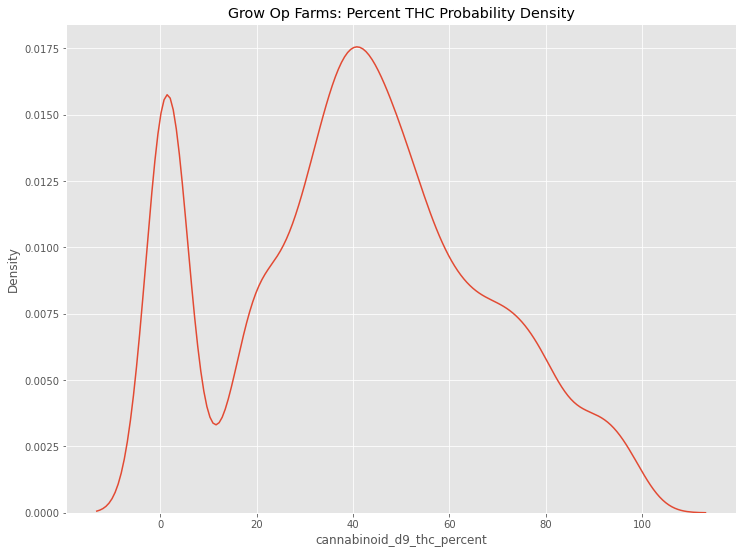

In [13]:
fig, ax = plt.subplots(figsize=(12,9))
sns.kdeplot(grow_op['cannabinoid_d9_thc_percent'], label='THC D9 %', ax=ax)
ax.set_title('Grow Op Farms: Percent THC Probability Density')
;

That appears to have fixed our decimal problem, but it introduced that bimodal distribution that was mentioned earlier. I'm going to assume this suggests there are two types of products, products designated low THC, and products designated high THC. To remedy this problem we will first try to determine if there is a feature in the data that is determinant to which normal distribution a test result should belong to. If that doesn't work we will
just use the local minimum between the two distributions to separate them.

The two features to check are lab_name and material_type. It is possible Grow Op Farms uses one lab for their low THC tests and one for their high. For material type, it is plausible that it determines if a product is low or high THC.

In [14]:
grow_op_by_lab = grow_op.groupby('lab_name')
green_tests = grow_op_by_lab.get_group('Green Grower Labs')
praxis_tests = grow_op_by_lab.get_group('Praxis Laboratory')

''

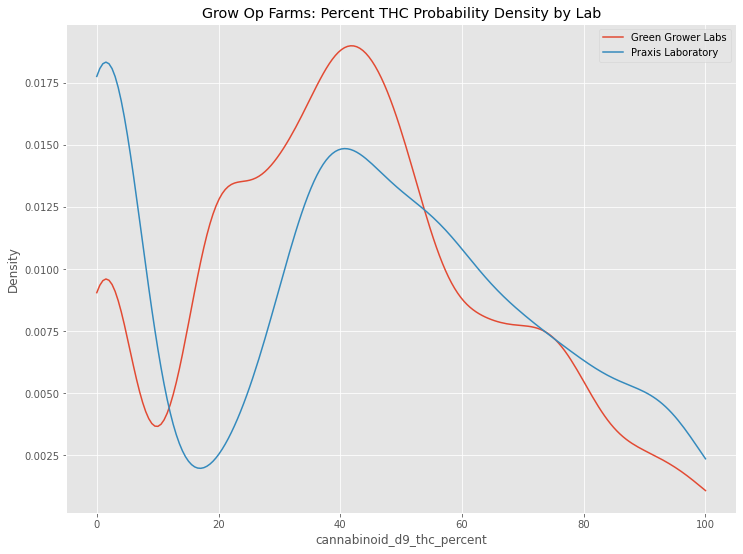

In [15]:
fig, ax = plt.subplots(figsize=(12,9))
sns.kdeplot(green_tests['cannabinoid_d9_thc_percent'], label='Green Grower Labs', ax=ax, clip=(0,100))
sns.kdeplot(praxis_tests['cannabinoid_d9_thc_percent'], label='Praxis Laboratory', ax=ax , clip=(0,100))
ax.set_title('Grow Op Farms: Percent THC Probability Density by Lab')
ax.legend()
;

Both labs are bimodal--so it doesn't appear Grow Op Farms sends low/high products to different labs. How about material type?

''

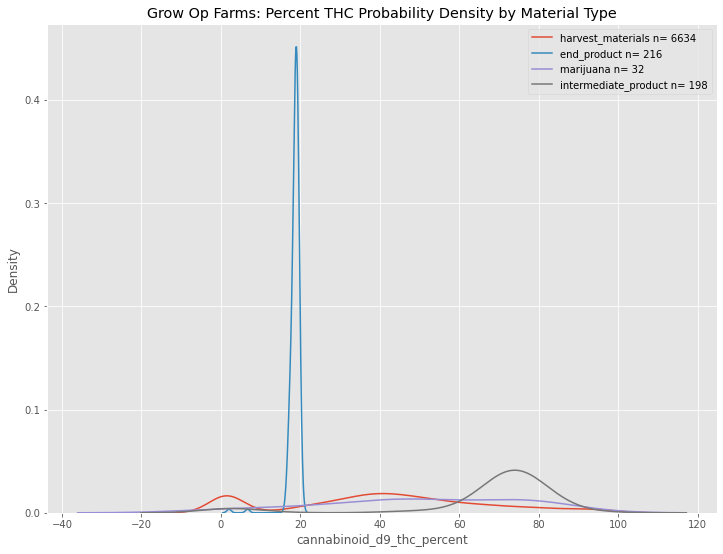

In [16]:
fig, ax = plt.subplots(figsize=(12,9))

for mat_type in grow_op['material_type'].unique():
    data = grow_op['cannabinoid_d9_thc_percent'][grow_op['material_type'] == mat_type]
    n = len(data)
    sns.kdeplot(data, label=mat_type + ' n= ' + str(n), ax=ax)
ax.set_title('Grow Op Farms: Percent THC Probability Density by Material Type')
ax.legend()
;

Almost all of the tests are for harvest materials. There are differences between the distribution, but not what we are looking for. However, this does highlight where we should focus our attention: harvest materials since due to the sample size and it'll have the largest business impact.

''

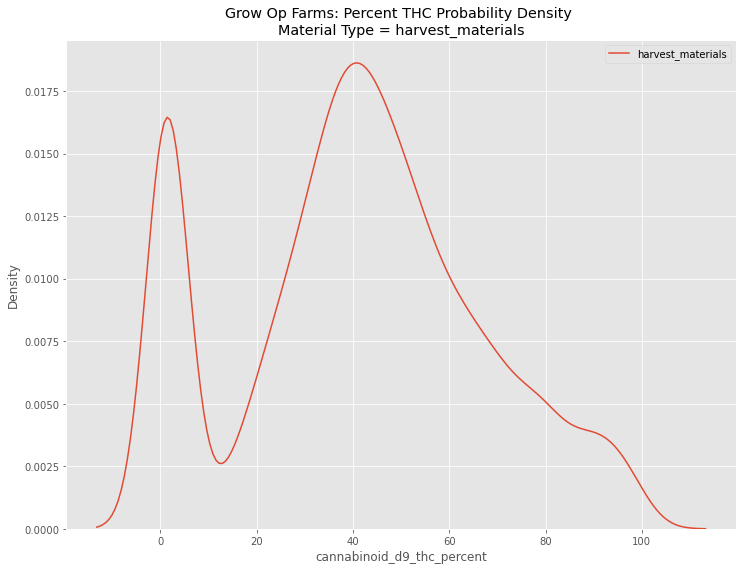

In [17]:
fig, ax = plt.subplots(figsize=(12,9))

sns.kdeplot(grow_op['cannabinoid_d9_thc_percent'][grow_op['material_type'] == 'harvest_materials']
            , label='harvest_materials', ax=ax)
ax.set_title('Grow Op Farms: Percent THC Probability Density \nMaterial Type = harvest_materials')
ax.legend()
;

So neither of those features were the reason behind this distribution. We will go ahead with option 2 and separate them by the KDE's local min.

local min (x,y): (12.4354, 0.0025)


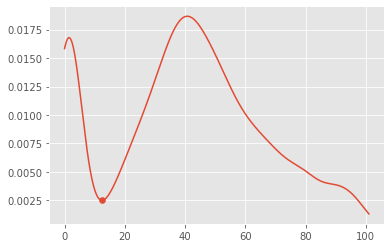

In [29]:
dens = sm.nonparametric.KDEUnivariate(grow_op['cannabinoid_d9_thc_percent'][grow_op['material_type'] == 'harvest_materials'])
dens.fit()
x = np.linspace(0,101,1000)
y = dens.evaluate(x)

x_min ,y_min = x[y[0:501].argmin()], min(y[0:501])
plt.plot(x,y)
plt.scatter(x_min, y_min)
print(f'local min (x,y): ({round(x_min, 4)}, {round(y_min, 4)})')

THC values below 12.435 will be removed from the data set as they are products that are intentionally low in THC. 

In [19]:
grow_op_high_thc = grow_op[grow_op['cannabinoid_d9_thc_percent'] >= 12.435]

''

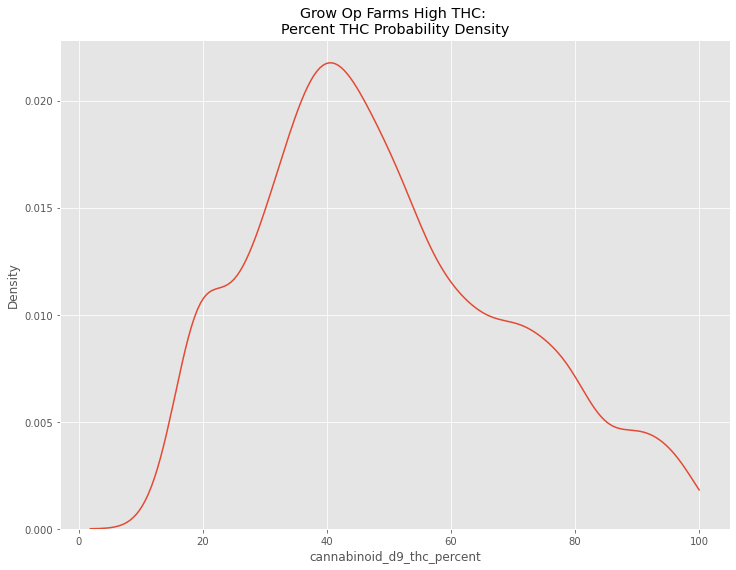

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
sns.kdeplot(grow_op_high_thc['cannabinoid_d9_thc_percent'], label='THC D9 %', ax=ax, clip=(0,100))
ax.set_title('Grow Op Farms High THC: \nPercent THC Probability Density')
;

Segmenting for high THC appears to give us a right skew normal distribution. We will go ahead and use this as our base dataset. Finally we can restrict our data to only look at harvest materials and groupby lab.

In [21]:
grow_op_high_thc = grow_op_high_thc[grow_op_high_thc['material_type'] == 'harvest_materials']
grow_op_by_lab = grow_op_high_thc.groupby('lab_name')
green_tests = grow_op_by_lab.get_group('Green Grower Labs')
praxis_tests = grow_op_by_lab.get_group('Praxis Laboratory')

''

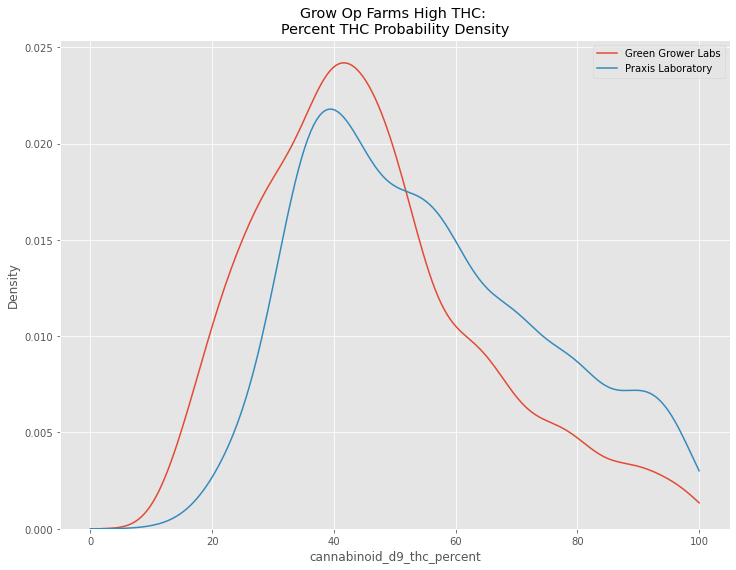

In [22]:
fig, ax = plt.subplots(figsize=(12,9))
sns.kdeplot(green_tests['cannabinoid_d9_thc_percent'], label='Green Grower Labs', ax=ax, clip=(0,100))
sns.kdeplot(praxis_tests['cannabinoid_d9_thc_percent'], label='Praxis Laboratory', ax=ax, clip=(0,100))
ax.set_title('Grow Op Farms High THC: \nPercent THC Probability Density')
ax.legend()
;

## Hypothesis Testing 

Now that we have our final dataset we can move onto hypothesis testing. Before stating our null hypothesis we need to know what type of test we are going to use--and in our case this comes down to if we can get our dataset to be normally distributed; so lets try a few transformations to make the distribution normal. Below there will be some transformations along with their QQ plots.

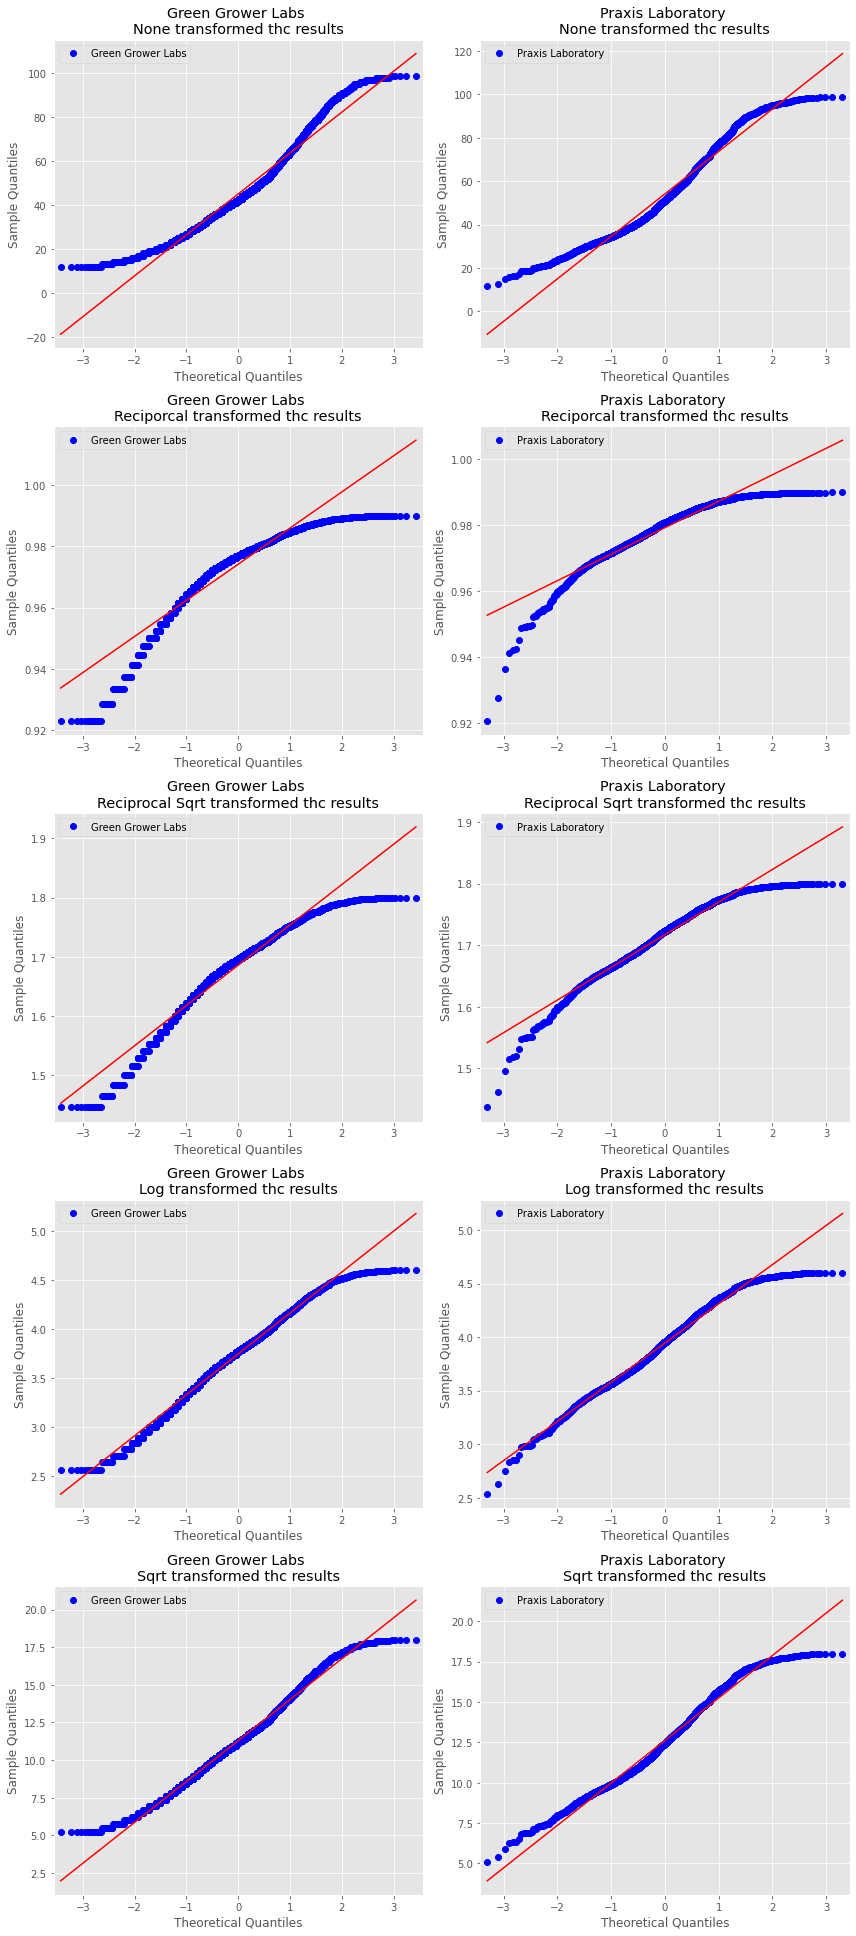

In [23]:
fig, axs = plt.subplots(5,2, figsize=(12,27))
transformer_dict = {1 : 'None'
                    , -1: 'Reciporcal'
                    , -.5: 'Reciprocal Sqrt'
                    , 0 :'Log'
                    , .5: 'Sqrt'}
for t,ax in zip(transformer_dict.keys(), range(5)):
    green_transformed = stats.boxcox(green_tests['cannabinoid_d9_thc_percent'], t)
    praxis_transformed = stats.boxcox(praxis_tests['cannabinoid_d9_thc_percent'], t)
    qqplot(green_transformed, ax=axs[ax][0], line='s', label='Green Grower Labs', lw=0)
    qqplot(praxis_transformed, ax=axs[ax][1], line='s', label='Praxis Laboratory', lw=0)
    axs[ax][0].set_title(f'Green Grower Labs \n{transformer_dict[t]} transformed thc results') # left graph
    axs[ax][1].set_title(f'Praxis Laboratory \n{transformer_dict[t]} transformed thc results') # right graph
    axs[ax][0].legend()
    axs[ax][1].legend()

fig.tight_layout()

No transformation appears to yield a normal distribution so we will rely on the Mann Whitney U test. Knowing this we can state our null and alternative hypothesis:
$$ h_0 = p(x_i > y_i) = .5 $$
$$ h_a = p(x_i > y_i) \neq .5 $$
$$ \alpha = .05 $$

Our null hypothesis is basically saying that after ordering both X and Y, if we choose some index i, there should be an equal probability that $x_i > y_i$ and $y_i > x_i$--meaning the probability would need to be .5. 

Now we can run our test and plot a graph of the results.

In [24]:
alpha = .05
stat, pval = stats.mannwhitneyu(green_tests['cannabinoid_d9_thc_percent']
                               , praxis_tests['cannabinoid_d9_thc_percent'])

if pval >= alpha:
    result = 'Pval >= alpha; fail to reject the null hypothesis'
else:
    result = 'Pval < alpha; reject the null hypothesis'

print(f'stat: {stat}, pval: {pval} \n{result}')

stat: 2560584.5, pval: 3.406385090507048e-60 
Pval < alpha; reject the null hypothesis


/home/austin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/austin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


''

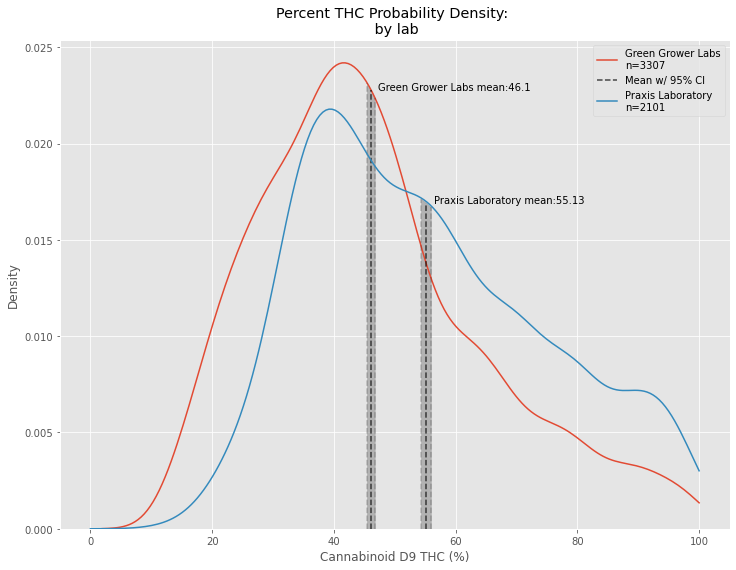

In [25]:
fig, ax = plt.subplots(figsize=(12,9))

test_results = {'Green Grower Labs': green_tests['cannabinoid_d9_thc_percent']
                ,'Praxis Laboratory': praxis_tests['cannabinoid_d9_thc_percent']}
mean_lables = ['Mean w/ 95% CI', '_nolegned_']
i = 0

for key, data in test_results.items():
    lower, upper, _ = bootstrap_confidence_interval(data)
    mean = np.mean(data)
    
    sns.kdeplot(data, label=f'{key}\nn={len(data)}', ax=ax, clip=(0,100))
    
    dens = sm.nonparametric.KDEUnivariate(data)
    dens.fit()
    x = np.linspace(lower, upper, 100) #restrict range to (0,100)
    y = dens.evaluate(x)
    
    ax.plot([lower, lower], [0, dens.evaluate(lower)], linestyle='--', alpha=.2, color='black')
    ax.plot([mean, mean], [0, dens.evaluate(mean)], linestyle='--' , alpha=.7, color='black', label=mean_lables[i])
    ax.plot([upper, upper], [0, dens.evaluate(upper)], linestyle='--' , alpha=.2, color='black')

    fill_between_x = np.linspace(lower, upper, 100)
    fill_between_y_0 = np.zeros(100)
    fill_between_y_1 = dens.evaluate(fill_between_x)
    ax.fill_between(fill_between_x, fill_between_y_0, fill_between_y_1, color='grey', alpha=.5)
    
    ax.text(mean*1.025, dens.evaluate(mean), f'{key} mean:{round(mean, 2)}')
    i += 1

ax.set_title('Percent THC Probability Density: \n by lab')
ax.set_xlabel('Cannabinoid D9 THC (%)')
ax.legend()
;

Both the Mann Whitney test and the visual boot strapped means confirm that Praxis Laboratory's would likely be the better choice to send lab tests to based solely on optimizing for THC contents.